In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('data/IMOEX.csv', sep=';')



In [435]:

print(df.head())
print(df.info())
print(df.describe())

#df = df[df['slug'] == 'USD/EUR']

# для MOEX
df = df.drop(columns=['TIME', 'VOLUME'], axis=0)
df.columns = df.columns.str.lower()


       DATE   TIME   OPEN   HIGH    LOW  CLOSE  VOLUME
0  05/01/99  00:00  45.60  45.60  45.60  45.60     0.0
1  06/01/99  00:00  46.79  46.79  46.79  46.79     0.0
2  10/01/99  00:00  49.72  49.72  49.72  49.72     0.0
3  11/01/99  00:00  49.60  49.60  49.60  49.60     0.0
4  12/01/99  00:00  48.07  48.07  48.07  48.07     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742 entries, 0 to 6741
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    6742 non-null   object 
 1   TIME    6742 non-null   object 
 2   OPEN    6742 non-null   float64
 3   HIGH    6742 non-null   float64
 4   LOW     6742 non-null   float64
 5   CLOSE   6742 non-null   float64
 6   VOLUME  6742 non-null   float64
dtypes: float64(5), object(2)
memory usage: 368.8+ KB
None
              OPEN         HIGH          LOW        CLOSE        VOLUME
count  6742.000000  6742.000000  6742.000000  6742.000000  6.742000e+03
mean   1622.275449  1635.803

        date   open   high    low  close
0 1999-01-05  45.60  45.60  45.60  45.60
1 1999-01-06  46.79  46.79  46.79  46.79
2 1999-01-10  49.72  49.72  49.72  49.72
3 1999-01-11  49.60  49.60  49.60  49.60
4 1999-01-12  48.07  48.07  48.07  48.07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742 entries, 0 to 6741
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6742 non-null   datetime64[ns]
 1   open    6742 non-null   float64       
 2   high    6742 non-null   float64       
 3   low     6742 non-null   float64       
 4   close   6742 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 263.5 KB
None
                                date         open         high          low  \
count                           6742  6742.000000  6742.000000  6742.000000   
mean   2012-07-04 10:12:46.775437568  1622.275449  1635.803290  1607.168742   
min              1999-01-05 00:00:00 

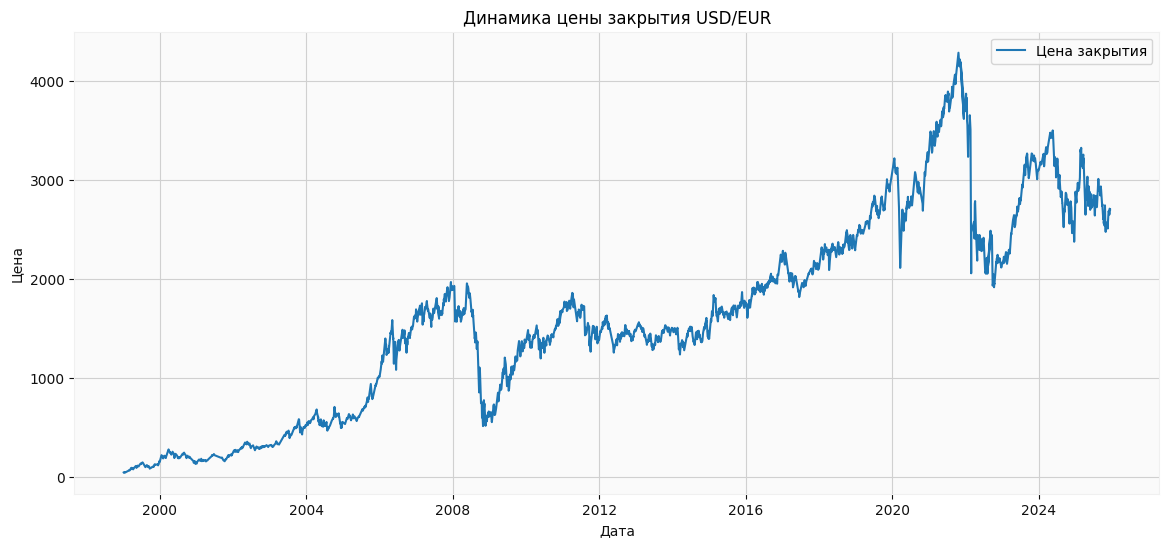

In [436]:



df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
#df = df[df['date'] > '2025-11-01']
df = df.sort_values(by='date').reset_index(drop=True)

print(df.head())
print(df.info())
print(df.describe())



# Визуализация цены закрытия
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['close'], label='Цена закрытия')
plt.title('Динамика цены закрытия USD/EUR')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()




In [437]:

df.drop_duplicates(inplace=True)

df.fillna(method='ffill', inplace=True)  # заполнение предыдущим значением

df['SMA_5'] = df['close'].rolling(window=5).mean()  # Скользящая средняя 5 дней
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['RSI'] = 100 - (100 / (1 + df['close'].diff(1).rolling(14).apply(lambda x: x[x > 0].sum() / abs(x[x < 0].sum()) if x[x < 0].sum() != 0 else 1)))
df['Volatility'] = df['close'].rolling(window=10).std()

# Лагированные значения (прошлые цены)
for i in range(1, 6):
    df[f'Close_lag_{i}'] = df['close'].shift(i)

# Целевая переменная (цена закрытия следующего дня)
df['Target'] = df['close'].shift(-1)

# Удаление строк с NaN после создания признаков
df.dropna(inplace=True)

# Выбор признаков для модели
features = ['open', 'high', 'low', 'close', 'SMA_5', 'SMA_10', 'RSI', 'Volatility'] + [f'Close_lag_{i}' for i in range(1, 6)]
X = df[features]
y = df['Target']


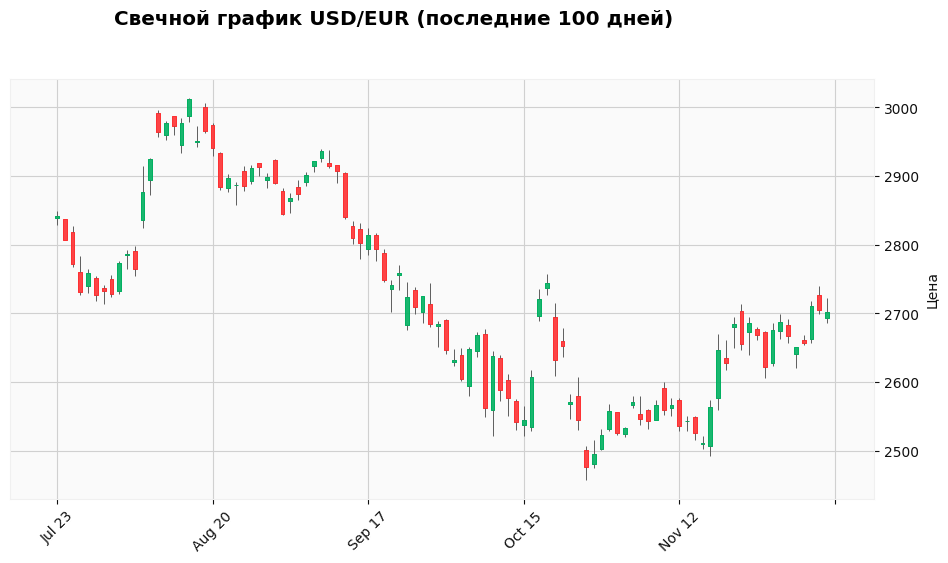

In [438]:
import mplfinance as mpf

# Выбираем последние 100 дней для наглядности
df_plot = df[['date', 'open', 'high', 'low', 'close']].tail(100).copy()
df_plot = df_plot.sort_values(by='date')
df_plot.set_index('date', inplace=True)

# Свечной график
mpf.plot(df_plot, type='candle', style='yahoo', 
          title='Свечной график USD/EUR (последние 100 дней)',
          ylabel='Цена',
          volume=False,
          figsize=(12, 6))


In [439]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [440]:

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)


MAE: 185.924141
MSE: 109406.142700
RMSE: 330.765994
R²: 0.614777


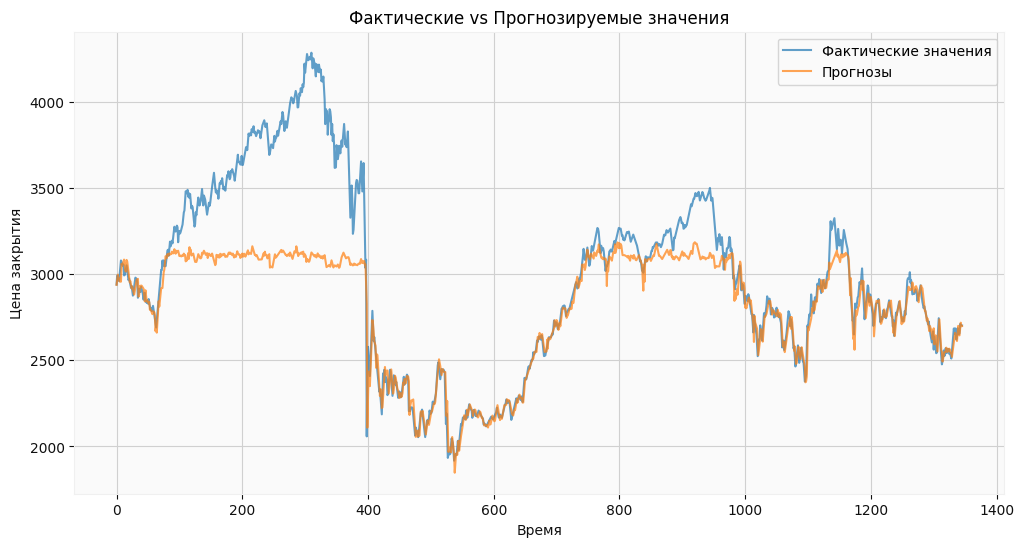

In [441]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Фактические значения', alpha=0.7)
plt.plot(y_pred, label='Прогнозы', alpha=0.7)
plt.title('Фактические vs Прогнозируемые значения')
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.show()

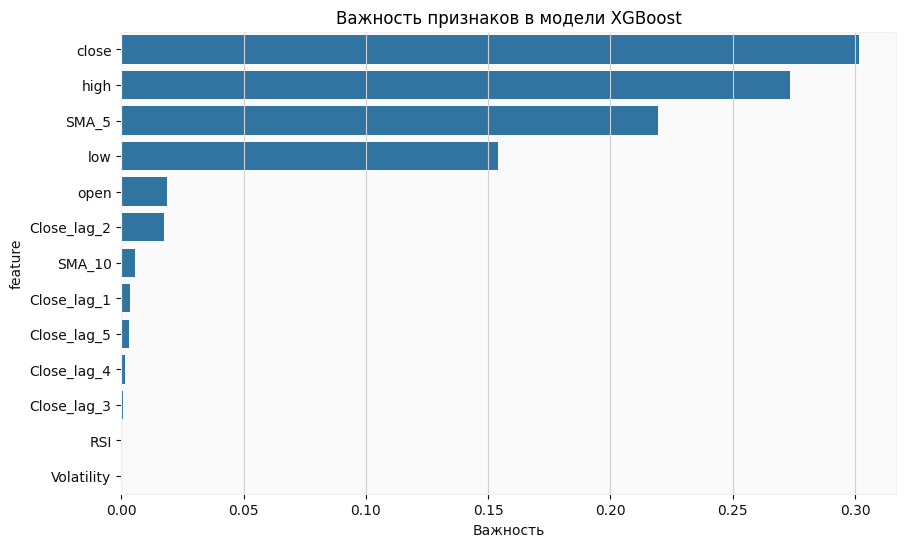

Топ-5 важных признаков:
  feature  importance
3   close    0.301810
1    high    0.273527
4   SMA_5    0.219428
2     low    0.154160
0    open    0.018677


In [442]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков в модели XGBoost')
plt.xlabel('Важность')
plt.show()

print("Топ-5 важных признаков:")
print(feature_importance.head())

               open     high      low    close
date                                          
2025-12-05  2662.05  2718.32  2656.92  2711.30
2025-12-08  2727.14  2739.74  2699.79  2705.17
2025-12-09  2693.36  2721.82  2686.32  2702.72
Даты свечей (t): [Timestamp('2025-10-29 00:00:00'), Timestamp('2025-10-30 00:00:00'), Timestamp('2025-10-31 00:00:00'), Timestamp('2025-11-01 00:00:00'), Timestamp('2025-11-03 00:00:00'), Timestamp('2025-11-05 00:00:00'), Timestamp('2025-11-06 00:00:00'), Timestamp('2025-11-07 00:00:00'), Timestamp('2025-11-10 00:00:00'), Timestamp('2025-11-11 00:00:00'), Timestamp('2025-11-12 00:00:00'), Timestamp('2025-11-13 00:00:00'), Timestamp('2025-11-14 00:00:00'), Timestamp('2025-11-17 00:00:00'), Timestamp('2025-11-18 00:00:00'), Timestamp('2025-11-19 00:00:00'), Timestamp('2025-11-20 00:00:00'), Timestamp('2025-11-21 00:00:00'), Timestamp('2025-11-24 00:00:00'), Timestamp('2025-11-25 00:00:00'), Timestamp('2025-11-26 00:00:00'), Timestamp('2025-11-27 00:00:00'),

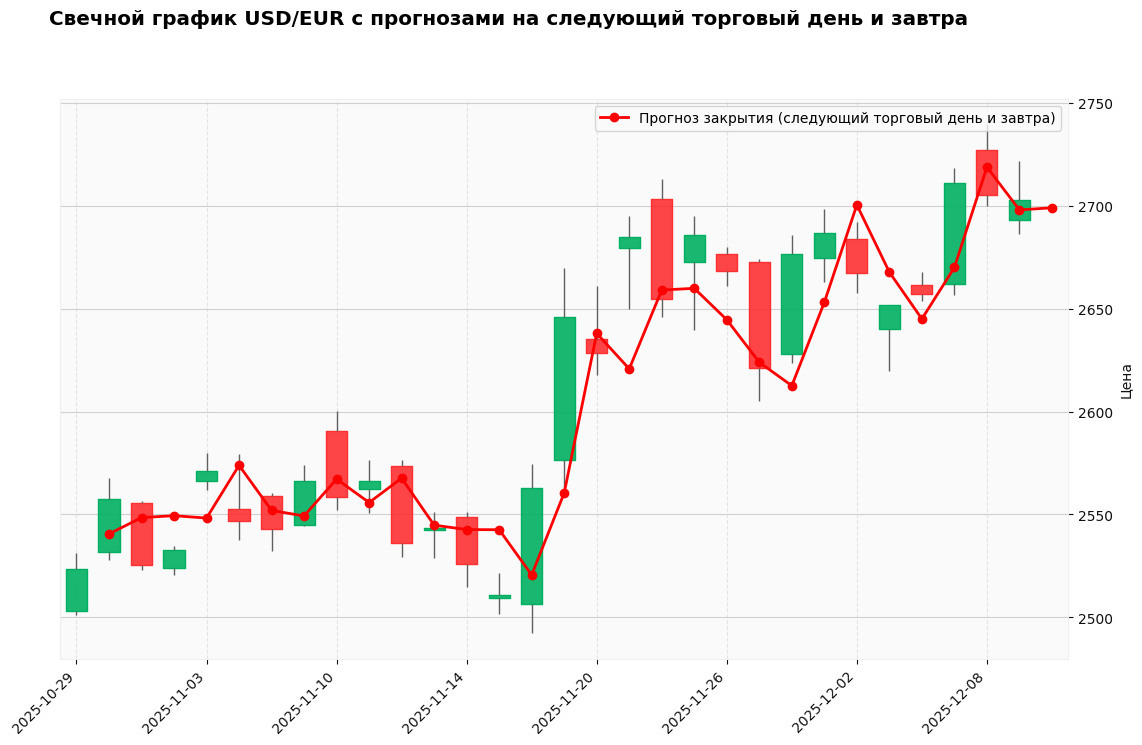

In [443]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter


N = 30

# 1–2. Подготовка данных (как раньше)
df_plot1 = df[['date', 'open', 'high', 'low', 'close']].copy()
df_plot1['date'] = pd.to_datetime(df_plot1['date'], format='%d/%m/%y')
df_plot1 = df_plot1.dropna(subset=['date'])
df_plot1 = df_plot1.sort_values(by='date')
df_plot1.set_index('date', inplace=True)
print(df_plot1.tail(3))

# 3. Берём последние N свечей
df_filtered = df_plot1.tail(N)
candle_dates = df_filtered.index


# 4. Получаем реальные следующие торговые дни (как раньше)
all_trading_dates = df_plot1.index
next_trading_days = []
for date in candle_dates:
    idx = all_trading_dates.get_loc(date)
    if idx + 1 < len(all_trading_dates):
        next_trading_days.append(all_trading_dates[idx + 1])
    else:
        next_trading_days.append(None)

# 5. Берём предсказания и фильтруем по реальным дням (как раньше)
y_pred_last_N = y_pred[-N:]


valid_forecast_dates = []
valid_predictions = []

for i, next_day in enumerate(next_trading_days):
    if next_day is not None:
        valid_forecast_dates.append(next_day)
        valid_predictions.append(y_pred_last_N[i])


y_pred_series = pd.Series(valid_predictions, index=valid_forecast_dates)


# 6. Добавляем прогноз на завтра (новый блок!)
tomorrow_date = candle_dates[-1] + pd.Timedelta(days=1)  # завтра
tomorrow_prediction = y_pred_last_N[-1]  # последнее предсказание


# Добавляем завтра в прогнозы
y_pred_series_with_tomorrow = y_pred_series.copy()
y_pred_series_with_tomorrow[tomorrow_date] = tomorrow_prediction


# 7. Проверяем данные
if len(df_filtered) == 0:
    raise ValueError("Нет данных для свечей")
if len(y_pred_series_with_tomorrow) == 0:
    print("Нет предсказаний для отображения")


print("Даты свечей (t):", candle_dates.tolist())
print("Даты прогнозов (t+1):", y_pred_series_with_tomorrow.index.tolist())


# 8. Строим график
# Создаём полный список дат: свечи + прогнозы (включая завтра)
forecast_index = pd.Index(y_pred_series_with_tomorrow.index)
all_dates = candle_dates.append(forecast_index).unique()
x_positions = range(len(all_dates))


fig, axlist = mpf.plot(
    df_filtered,
    type='candle',
    style='yahoo',
    title=f'Свечной график USD/EUR с прогнозами на следующий торговый день и завтра',
    ylabel='Цена',
    volume=False,
    figsize=(14, 8),
    returnfig=True,
    xrotation=45,
    datetime_format='%Y-%m-%d'
)

# Находим позиции прогнозов на оси X
forecast_x = [all_dates.get_loc(date) for date in y_pred_series_with_tomorrow.index]


axlist[0].plot(
    forecast_x,
    y_pred_series_with_tomorrow.values,
    color='red',
    linewidth=2,
    marker='o',
    markersize=6,
    label='Прогноз закрытия (следующий торговый день и завтра)',
    zorder=10
)

axlist[0].set_xlim(-0.5, len(all_dates) - 0.5)
axlist[0].xaxis.set_major_locator(AutoDateLocator())
plt.setp(axlist[0].xaxis.get_majorticklabels(), rotation=45, ha='right')


axlist[0].legend()
axlist[0].grid(True, which='major', axis='x', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()
